In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
import sys
sys.path.append("../")
sys.path.append("../imagen/")

from helpers import *
from imagen_pytorch import Unet, Imagen, ImagenTrainer, NullUnet

/vol/bitbucket/pn222/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed_value)

In [4]:
RUN_NAME = "64_PRP_rot904_sep_3e-4"
BASE_DIR = f"/vol/bitbucket/pn222/models/{RUN_NAME}"

In [5]:
with open(BASE_DIR + f"/metrics.pkl", "rb") as file:
    metric_dict = pickle.load(file)

In [6]:
x = [5*x for x in range(len(metric_dict['train']['kl_div']))]
metrics = list(metric_dict["train"].keys())

train_data = metric_dict["train"]
test_data  = metric_dict["test"]

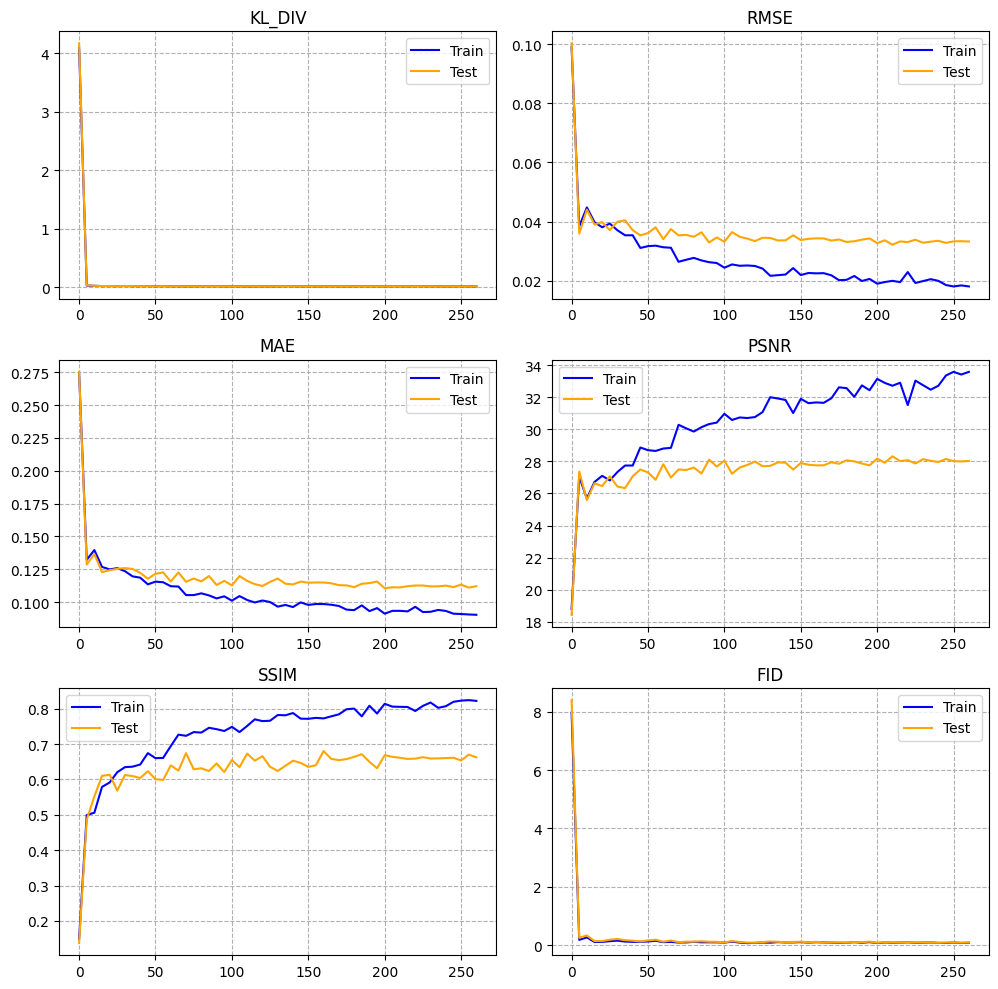

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for i, metric in enumerate(metrics):
    row = i // 2 ; col = i % 2  
    ax = axs[row, col]

    ax.plot(x, train_data[metric], color='blue', label='Train')
    ax.plot(x, test_data[metric], color='orange', label='Test')
    ax.set_title(metric.upper()) 
    ax.legend()
    ax.grid(True, linestyle='--')

plt.tight_layout()  
plt.savefig(f"../pngs/64_PRP/metrics_{RUN_NAME}.png", bbox_inches="tight")
plt.show()

In [8]:
from collections import Counter

def get_elements_with_highest_occurrence(arr):
    counter = Counter(arr)
    max_occurrence = max(counter.values())
    elements = [element for element, count in counter.items() if count == max_occurrence]
    return elements

best_epochs = {
    "kl_div": np.argmin(test_data["kl_div"]) * 5,
    "rmse": np.argmin(test_data["rmse"]) * 5,
    "mae": np.argmin(test_data["mae"]) * 5,
    "psnr": np.argmax(test_data["psnr"]) * 5, 
    "ssim": np.argmax(test_data["ssim"]) * 5, 
    "fid": np.argmin(test_data["fid"]) * 5,
}

best_epochs = get_elements_with_highest_occurrence(best_epochs.values())
best_epoch = best_epochs[-1]
print(f"Best epoch: {best_epoch}")

Best epoch: 210


In [9]:
unet1 = Unet(
    dim = 32,
    cond_dim = 1024,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
)  

unets = [unet1]

class DDPMArgs:
    def __init__(self):
        pass
    
args = DDPMArgs()
args.batch_size = 16
args.image_size = 64 ; args.o_size = 64 ; args.n_size = 128 ;
args.continuous_embed_dim = 64*64*4
args.dataset_path = f"/vol/bitbucket/pn222/satellite/dataloader/{args.o_size}_PRP"
args.datalimit = False
args.lr = 3e-4
args.mode = "tp"

train_dataloader, test_dataloader = get_satellite_data(args)
_ = len(train_dataloader) ; _ = len(test_dataloader)

if '1k' in RUN_NAME:
    timesteps = 1000
else:
    timesteps = 250

imagen = Imagen(
    unets = unets,
    image_sizes = (64),
    timesteps = 250,
    cond_drop_prob = 0.1,
    condition_on_continuous = True,
    continuous_embed_dim = args.continuous_embed_dim,
)

ckpt_trainer_path = f"{BASE_DIR}/models/64_PRP/ckpt_trainer_1_{best_epoch:03}.pt"
trainer = ImagenTrainer(imagen, lr=args.lr, verbose=False).cuda()
trainer.load(ckpt_trainer_path)  

def get_images(dataloader, random_idx):
    batch_idx = dataloader.random_idx[random_idx[0]]
    img_64, _, img_tp = dataloader.get_batch(batch_idx)
    cond_embeds = img_64.reshape(img_64.shape[0], -1).float().cuda()
    ema_sampled_images = imagen.sample(
                batch_size = img_64.shape[0],          
                cond_scale = 3.,
                continuous_embeds=cond_embeds,
        )
    
    y_true = img_tp.cpu()
    y_pred = ema_sampled_images.cpu()

    return y_true, y_pred

100%|███████████████████████████████████████████| 51/51 [00:34<00:00,  1.49it/s]


Sampling: 100%|███████████████████████████████| 250/250 [00:28<00:00,  8.77it/s]
1it [00:28, 28.62s/it]


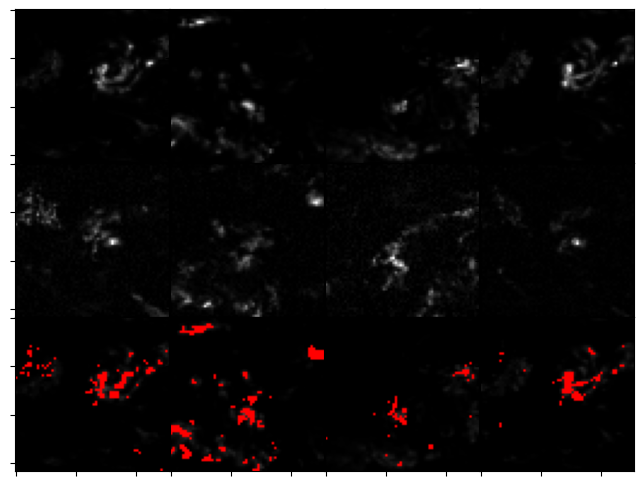

In [10]:
random_idx = [5]
dataloader = test_dataloader
y_true, y_pred = get_images(dataloader, random_idx)
save_images_v2(dataloader, y_true, y_pred, path=f"../pngs/64_PRP/test_sample_{RUN_NAME}.png")

Sampling: 100%|███████████████████████████████| 250/250 [00:27<00:00,  9.12it/s]
1it [00:27, 27.68s/it]


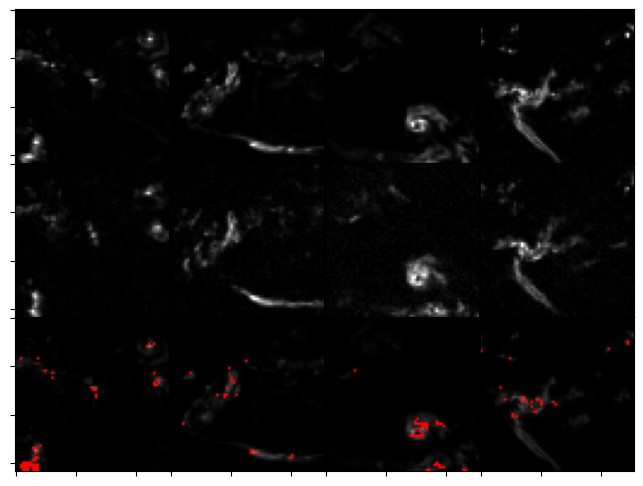

In [11]:
dataloader = train_dataloader
y_true, y_pred = get_images(dataloader, random_idx)
save_images_v2(dataloader, y_true, y_pred, path=f"../pngs/64_PRP/train_sample_{RUN_NAME}.png")